In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

import xarray as xr
# from agrifoodpy.population.population_data import UN

FAOSTAT food balance sheets describe food supply patterns from countries and regions as a function of time and food commodity.
Latest FAOSTAT data can be downloaded from the FAO website:
- https://www.fao.org/faostat/en/#data/FBSH for data released until 2013 utilizing old methodology
- https://www.fao.org/faostat/en/#data/FBS for data published since 2010 utilizing new methodology

The array created here stores data from the old methodology until 2009, and then new methodology from 2011 on.

For both datasets, select the 'All Data Normalized' option on the right hand side panel of the sites to get two compressed folders which include the two files named in the cell below.

In this notebook the values are extracted and stored in an easy to manage xarray DataSet which is then read by the AgriFoodPy package when the FAOSTAT dataset is imported.

```python
from agrifoodpy.food.food_supply import FAOSTAT
```


## Food balance sheets

The dimensions of the array include:

- **Year**
- **Region code**
- Region name
- **Item code**
- Item name
- Item origin
- Item group

The main named dimensions shown in bold are used to index the array, while the rest are used for labelling. These can be useful when grouping into broader categories (Animal vs vegetal origin, or food groups)

The Dataset contains the following element DataArrays:

- Stock Variation
- Losses
- Processing
- Food
- Other uses (non-food)
- Residuals
- Tourist consumption
- Domestic supply quantity
- Production
- Feed
- Seed
- Import Quantity
- Export Quantity

## Nutrient data

Additionally, basic nutrient data is derived from the total consumption values by weight and the reported intakes in the following elements:

- Food supply (kcal/capita/day)
- Protein supply quantity (g/capita/day)
- Fat supply quantity (g/capita/day)

Here we generate an xarray Dataset of nutrients per weight as a function of year and region. This is stored in a separate file which can be imported in agrifoopy as

``` python
from agrifoopy.food.food_supply import Nutrients_FAOSTAT
```

## Population data

Population data is also contained in the input CSV files. A DataArray is generated here and stored as an alternative to UN population data.
Population estimations from 1961 to 2020 are provided for each year and region defined in the FAOSTAT database.
The array created here can be imported in agrifoodpy as

``` python
from agrifoopy.population.population import FAOSTAT
```

In [2]:
# Read historic and current data
# (-2013)
fbs_csv_1 = '../data/food/FoodBalanceSheetsHistoric_E_All_Data_(Normalized).csv'
# (2010-)
fbs_csv_2 = '../data/food/FoodBalanceSheets_E_All_Data_(Normalized).csv'

In [3]:
fbs_1 = pd.read_csv(fbs_csv_1, encoding = 'latin1') # 1961 - 2013
fbs_2 = pd.read_csv(fbs_csv_2, encoding = 'latin1') # 2010 - present

# We will prefer new methodology over old, so will drop 2010-2013 year range from old data
fbs_1 = fbs_1[fbs_1['Year'].isin(np.arange(1961, 2010))]

fbs = pd.concat([fbs_2, fbs_1], ignore_index=True, sort=False)
# fbs = fbs[fbs['Area Code'] == 229]

fbs = fbs[['Area Code', 'Area', 'Element', 'Element Code', 'Item', 'Item Code', 'Year', 'Unit', 'Value']]
years = np.unique(fbs['Year'])

'Rice and products' and 'Groundnuts' changed name and code from one methodology to another. We will keep the new codes and names

'Miscellaneous', 'Milk - Excluding Butter' and 'Eggs' have two different measurement flags, each with a different 'Item Code'. Will keep the highest Item Code: 2948 & 2949 for the later two.

In [4]:
nuts_old_code = fbs_1[fbs_1['Item'] == 'Groundnuts (Shelled Eq)'].iloc[0]['Item Code']
rice_old_code = fbs_1[fbs_1['Item'] == 'Rice (Milled Equivalent)'].iloc[0]['Item Code']

nuts_new_code = fbs_2[fbs_2['Item'] == 'Groundnuts'].iloc[0]['Item Code']
rice_new_code = fbs_2[fbs_2['Item'] == 'Rice and products'].iloc[0]['Item Code']

milk_codes = pd.unique(fbs[fbs['Item'] == 'Milk - Excluding Butter']['Item Code'])
eggs_codes = pd.unique(fbs[fbs['Item'] == 'Eggs']['Item Code'])


print(f'Groundnuts: old code = {nuts_old_code}, new code = {nuts_new_code}')
print(f'Rice and products: old code = {rice_old_code}, new code = {rice_new_code}')

print(f'Milk: old code = {milk_codes[0]}, new code = {milk_codes[1]}')
print(f'Eggs: old code = {eggs_codes[0]}, new code = {eggs_codes[1]}')

# print('Milk codes:', milk_codes)
# print('Eggs codes:', eggs_codes)

Groundnuts: old code = 2556, new code = 2552
Rice and products: old code = 2805, new code = 2807
Milk: old code = 2948, new code = 2848
Eggs: old code = 2949, new code = 2744


In [5]:
# We'll rename some of the items due to changes in naming convention
fbs.loc[fbs['Item Code'] == rice_old_code, 'Item'] = "Rice and products"
fbs.loc[fbs['Item Code'] == rice_old_code, 'Item Code'] = rice_new_code

fbs.loc[fbs['Item Code'] == nuts_old_code, 'Item'] = "Groundnuts"
fbs.loc[fbs['Item Code'] == nuts_old_code, 'Item Code'] = nuts_new_code

# Also, will remove the 'Miscellaneous' item as it has incomplete data
fbs.drop(fbs.loc[fbs['Item'] == 'Miscellaneous'].index, inplace=True)

# Also, will remove the 'Miscellaneous' item as it has incomplete data
fbs.drop(fbs.loc[fbs['Item'] == 'Grand Total'].index, inplace=True)

# Finally, drop all duplicates of Eggs and Milk, store population data for later and drop it

population = fbs.loc[(fbs['Item Code'] == 2501) & (fbs["Element"] == 'Total Population - Both sexes')]
fbs.drop(fbs.loc[fbs['Item Code'].isin([milk_codes[1], eggs_codes[1], 2501])].index, inplace=True)

fbs

,Area Code,Area,Element,Element Code,Item,Item Code,Year,Unit,Value
405,13,Bahrain,Food supply (kcal/capita/day),664,Vegetal Products,2903,2019,kcal/capita/day,2668.00
406,13,Bahrain,Food supply (kcal/capita/day),664,Vegetal Products,2903,2020,kcal/capita/day,2644.00
464,13,Bahrain,Food supply (kcal),661,Vegetal Products,2903,2019,million kcal,1597964.48
465,13,Bahrain,Food supply (kcal),661,Vegetal Products,2903,2020,million kcal,1642113.05
527,13,Bahrain,Protein supply quantity (g/capita/day),674,Vegetal Products,2903,2019,g/capita/day,42.78
...,...,...,...,...,...,...,...,...,...
14540143,5817,Net Food Importing Developing Countries,Fat supply quantity (g/capita/day),684,Infant food,2680,2005,g/capita/day,0.00
14540144,5817,Net Food Importing Developing Countries,Fat supply quantity (g/capita/day),684,Infant food,2680,2006,g/capita/day,0.00
14540145,5817,Net Food Importing Developing Countries,Fat supply quantity (g/capita/day),684,Infant food,2680,2007,g/capita/day,0.01
14540146,5817,Net Food Importing Developing Countries,Fat supply quantity (g/capita/day),684,Infant food,2680,2008,g/capita/day,0.01


# Food balance sheets

## Region and Item codes

In [6]:
area_names = pd.unique(fbs['Area'])
area_codes = pd.unique(fbs['Area Code'])

sorting = np.argsort(area_codes)
area_codes = area_codes[sorting]
area_names = area_names[sorting]

for name, code in zip(area_names, area_codes):
    print(code, name)

1 Armenia
2 Afghanistan
3 Albania
4 Algeria
7 Angola
8 Antigua and Barbuda
9 Argentina
10 Australia
11 Austria
12 Bahamas
13 Bahrain
14 Barbados
15 Belgium-Luxembourg
16 Bangladesh
17 Bermuda
18 Bhutan
19 Bolivia (Plurinational State of)
20 Botswana
21 Brazil
23 Belize
25 Solomon Islands
26 Brunei Darussalam
27 Bulgaria
28 Myanmar
29 Burundi
32 Cameroon
33 Canada
35 Cabo Verde
37 Central African Republic
38 Sri Lanka
39 Chad
40 Chile
41 China, mainland
44 Colombia
45 Comoros
46 Congo
48 Costa Rica
49 Cuba
50 Cyprus
51 Czechoslovakia
52 Azerbaijan
53 Benin
54 Denmark
55 Dominica
56 Dominican Republic
57 Belarus
58 Ecuador
59 Egypt
60 El Salvador
62 Ethiopia PDR
63 Estonia
66 Fiji
67 Finland
68 France
70 French Polynesia
72 Djibouti
73 Georgia
74 Gabon
75 Gambia
79 Germany
80 Bosnia and Herzegovina
81 Ghana
83 Kiribati
84 Greece
86 Grenada
89 Guatemala
90 Guinea
91 Guyana
93 Haiti
95 Honduras
96 China, Hong Kong SAR
97 Hungary
98 Croatia
99 Iceland
100 India
101 Indonesia
102 Iran (Islam

In [7]:
item_names = pd.unique(fbs['Item'])
item_codes = pd.unique(fbs['Item Code'])

# Sort by item code
sorting = np.argsort(item_codes)
item_codes = item_codes[sorting]
item_names = item_names[sorting]

In [8]:
# Read the item code, name and group data and create an array
# with the groups for each entry on item_codes / item_names
groups = pd.read_csv("../data/food/FAOSTAT_data_10-25-2022.csv")
groups = groups.drop(groups[groups["Item Group"] == "Grand Total"].index)
groups

,Item Group Code,Item Group,Item Code,Item,Factor,HS Code,HS07 Code,HS12 Code,CPC Code
0,2905,Cereals - Excluding Beer,2511,Wheat and products,1,NaN,NaN,NaN,S2511
2,2903,Vegetal Products,2511,Wheat and products,1,NaN,NaN,NaN,S2511
3,2905,Cereals - Excluding Beer,2807,Rice and products,1,NaN,NaN,NaN,S2807
5,2903,Vegetal Products,2807,Rice and products,1,NaN,NaN,NaN,S2807
6,2905,Cereals - Excluding Beer,2513,Barley and products,1,NaN,NaN,NaN,S2513
...,...,...,...,...,...,...,...,...,...
286,2961,"Aquatic Products, Other",2775,Aquatic Plants,1,NaN,NaN,NaN,S2775
289,2928,Miscellaneous,2680,Infant food,1,NaN,NaN,NaN,S2680
290,2903,Vegetal Products,2680,Infant food,1,NaN,NaN,NaN,S2680
292,2928,Miscellaneous,2899,Miscellaneous,1,NaN,NaN,NaN,S2899


In [9]:
item_groups = []
item_origins = []

# First check the origin of the items

for code, name  in zip(item_codes, item_names):
    
    g = groups["Item Group"][groups["Item Code"] == code]    
    
    if "Vegetal Products" in g.to_numpy():
        item_origins.append("Vegetal Products")
        
    elif "Animal Products" in g.to_numpy():
        item_origins.append("Animal Products")
    
    elif code < 2940:
        item_origins.append("Vegetal Products")

    else:
        item_origins.append("Animal Products")

In [10]:
# Remove Vegetal and Animal origins from item list and then repeat with item groups:
      
groups = groups.drop(groups[groups["Item Group"] == "Animal Products"].index)
groups = groups.drop(groups[groups["Item Group"] == "Vegetal Products"].index)

for code, name  in zip(item_codes, item_names):
    
    g = groups["Item Group"][groups["Item Code"] == code].to_numpy()
    
    try:
        item_groups.append(g[0])
        
    except IndexError:
        item_groups.append(name)

In [11]:
print(len(item_codes), " Food items\n")

for name, code, group, origin in zip(item_names, item_codes, item_groups, item_origins):
    print(code, name, group, origin)

117  Food items

2511 Wheat and products Cereals - Excluding Beer Vegetal Products
2513 Barley and products Cereals - Excluding Beer Vegetal Products
2514 Maize and products Cereals - Excluding Beer Vegetal Products
2515 Rye and products Cereals - Excluding Beer Vegetal Products
2516 Oats Cereals - Excluding Beer Vegetal Products
2517 Millet and products Cereals - Excluding Beer Vegetal Products
2518 Sorghum and products Cereals - Excluding Beer Vegetal Products
2520 Cereals, Other Cereals - Excluding Beer Vegetal Products
2531 Potatoes and products Starchy Roots Vegetal Products
2532 Cassava and products Starchy Roots Vegetal Products
2533 Sweet potatoes Starchy Roots Vegetal Products
2534 Roots, Other Starchy Roots Vegetal Products
2535 Yams Starchy Roots Vegetal Products
2536 Sugar cane Sugar Crops Vegetal Products
2537 Sugar beet Sugar Crops Vegetal Products
2541 Sugar non-centrifugal Sugar & Sweeteners Vegetal Products
2542 Sugar (Raw Equivalent) Sugar & Sweeteners Vegetal Product

## Element codes

In [12]:
# Element codes, units and names. Remove population data
element_codes = pd.unique(fbs['Element Code'])
element_names = pd.unique(fbs['Element'])
element_units= []

for code in element_codes:
    unit = fbs[fbs['Element Code'] == code].iloc[0]['Unit']
    element_units.append(unit)

element_units = np.array(element_units)

# Sort by item code
sorting = np.argsort(element_codes)
element_codes = element_codes[sorting]
element_names = element_names[sorting]
element_units = element_units[sorting]
    
for i, (code, name) in enumerate(zip(element_codes, element_names)):
    print(code, element_units[i], name )

645 kg Food supply quantity (kg/capita/yr)
661 million kcal Food supply (kcal)
664 kcal/capita/day Food supply (kcal/capita/day)
671 g Protein supply quantity (g)
674 g/capita/day Protein supply quantity (g/capita/day)
681 g Fat supply quantity (g)
684 g/capita/day Fat supply quantity (g/capita/day)
5072 1000 tonnes Stock Variation
5123 1000 tonnes Losses
5131 1000 tonnes Processing
5142 1000 tonnes Food
5154 1000 tonnes Other uses (non-food)
5170 1000 tonnes Residuals
5171 1000 tonnes Tourist consumption
5301 1000 tonnes Domestic supply quantity
5511 1000 tonnes Production
5521 1000 tonnes Feed
5527 1000 tonnes Seed
5611 1000 tonnes Import Quantity
5911 1000 tonnes Export Quantity


## Filling incomplete data and store into array

Checking for incomplete data shows that several Items are not present in all areas, and some items without certain nutrients are ommited from the data.
We will fix that to have a rectangular array to facilitate usage with xarray. When data is not present, we will fill with `np.NaN`

In [13]:
# We define indexes for each of the dimensions of the data
iy = fbs['Year'] - 1961

# Some numpy trickery to get the indices for the area, elements and items
ia = np.nonzero(fbs['Area Code'].to_numpy()[:, None] == area_codes)[1]
ie = np.nonzero(fbs['Element Code'].to_numpy()[:, None] == element_codes)[1]
ic = np.nonzero(fbs['Item Code'].to_numpy()[:, None] == item_codes)[1]

# We compute the index in the flattened array
ipos = ia * len(years) * len(element_codes) * len(item_codes) + \
       iy * len(element_codes) * len(item_codes) + \
       ie * len(item_codes) + \
       ic

ipos = ipos.astype(int)

In [14]:
# Create 1d array filled with np.NaN
fbs_arr = np.ones(len(area_codes)*len(years)*len(element_codes)*len(item_codes))*np.NaN
fbs_arr[ipos] = fbs['Value']

# Reshape array to desired shape
fbs_arr = fbs_arr.reshape((len(area_codes), len(years), len(element_codes), len(item_codes)))



In [15]:
element_names

array(['Food supply quantity (kg/capita/yr)', 'Food supply (kcal)',
       'Food supply (kcal/capita/day)', 'Protein supply quantity (g)',
       'Protein supply quantity (g/capita/day)',
       'Fat supply quantity (g)', 'Fat supply quantity (g/capita/day)',
       'Stock Variation', 'Losses', 'Processing', 'Food',
       'Other uses (non-food)', 'Residuals', 'Tourist consumption',
       'Domestic supply quantity', 'Production', 'Feed', 'Seed',
       'Import Quantity', 'Export Quantity'], dtype=object)

In [16]:
data = xr.Dataset(
    data_vars = dict(

        stock=(["Region", "Year", "Item"], fbs_arr[:,:,4]),
        losses=(["Region", "Year", "Item"], fbs_arr[:,:,5]),
        processing=(["Region", "Year", "Item"], fbs_arr[:,:,6]),
        food=(["Region", "Year", "Item"], fbs_arr[:,:,7]),
        other=(["Region", "Year", "Item"], fbs_arr[:,:,8]),
        residual=(["Region", "Year", "Item"], fbs_arr[:,:,9]),
        tourist=(["Region", "Year", "Item"], fbs_arr[:,:,10]),
        domestic=(["Region", "Year", "Item"], fbs_arr[:,:,11]),
        production=(["Region", "Year", "Item"], fbs_arr[:,:,12]),
        feed=(["Region", "Year", "Item"], fbs_arr[:,:,13]),
        seed=(["Region", "Year", "Item"], fbs_arr[:,:,14]),
        imports=(["Region", "Year", "Item"], fbs_arr[:,:,15]),
        exports=(["Region", "Year", "Item"], fbs_arr[:,:,16]),
        
    ),
    coords = {
        "Region":("Region", area_codes),
        "Region_name":("Region", area_names),
        "Year":("Year", years),
        "Item":("Item", item_codes),
        "Item_name":("Item", item_names),     
        "Item_group":("Item", item_groups),     
        "Item_origin":("Item", item_origins),        
    }
)

Checking that the arrays are indexed correctly

In [17]:
data

<xarray.Dataset>
Dimensions:      (Region: 230, Year: 60, Item: 117)
Coordinates:
  * Region       (Region) int64 1 2 3 4 7 8 9 ... 5707 5801 5802 5803 5815 5817
    Region_name  (Region) object 'Armenia' ... 'Net Food Importing Developing...
  * Year         (Year) int64 1961 1962 1963 1964 1965 ... 2017 2018 2019 2020
  * Item         (Item) int64 2511 2513 2514 2515 2516 ... 2948 2949 2960 2961
    Item_name    (Item) object 'Wheat and products' ... 'Aquatic Products, Ot...
    Item_group   (Item) <U24 'Cereals - Excluding Beer' ... 'Aquatic Products...
    Item_origin  (Item) <U16 'Vegetal Products' ... 'Animal Products'
Data variables: (12/13)
    stock        (Region, Year, Item) float64 nan nan nan nan ... 0.83 3.58 0.0
    losses       (Region, Year, Item) float64 nan nan nan ... 5.062e+05 0.0
    processing   (Region, Year, Item) float64 nan nan nan nan ... 0.75 0.85 0.0
    food         (Region, Year, Item) float64 nan nan nan ... 1.0 1.196e+03 nan
    other        (Region, Year, Item) float64 nan nan nan nan ... 524.0 nan nan
    residual     (Region, Year, Item) float64 nan nan nan nan ... nan nan nan
    ...           ...
    domestic     (Region, Year, Item) float64 nan nan nan ... 0.0 319.4 149.3
    production   (Region, Year, Item) float64 nan nan nan nan ... -183.0 0.0 nan
    feed         (Region, Year, Item) float64 nan nan nan nan ... nan nan nan
    seed         (Region, Year, Item) float64 nan nan nan ... 1.864e+04 148.9
    imports      (Region, Year, Item) float64 nan nan nan ... 2.558e+04 200.9
    exports      (Region, Year, Item) float64 nan nan nan nan ... 0.0 868.2 nan

In [18]:
print(fbs[(fbs["Area Code"]==229) &
          (fbs["Year"]==2019) &
          (fbs["Element Code"]==5142) &
          (fbs["Item Code"]== 2511)]['Value'].values)

print(data["food"].sel(Region=229, 
               Year=2019, 
               Item=2511).values)

[6789.]
1314.0


In [19]:
encoding = {}
for data_var in data.data_vars:
    encoding[data_var] = {"dtype":"float32", "zlib": True, "complevel": 5}
    
data.to_netcdf("data/FAOSTAT.nc", encoding=encoding)

# Population

In [20]:
population

,Area Code,Area,Element,Element Code,Item,Item Code,Year,Unit,Value
0,2,Afghanistan,Total Population - Both sexes,511,Population,2501,2010,1000 persons,29186.0
1,2,Afghanistan,Total Population - Both sexes,511,Population,2501,2011,1000 persons,30117.0
2,3,Albania,Total Population - Both sexes,511,Population,2501,2010,1000 persons,2948.0
3,3,Albania,Total Population - Both sexes,511,Population,2501,2011,1000 persons,2929.0
4,4,Algeria,Total Population - Both sexes,511,Population,2501,2010,1000 persons,35977.0
...,...,...,...,...,...,...,...,...,...
14465810,5817,Net Food Importing Developing Countries,Total Population - Both sexes,511,Population,2501,2005,1000 persons,1121528.0
14465811,5817,Net Food Importing Developing Countries,Total Population - Both sexes,511,Population,2501,2006,1000 persons,1143987.0
14465812,5817,Net Food Importing Developing Countries,Total Population - Both sexes,511,Population,2501,2007,1000 persons,1166748.0
14465813,5817,Net Food Importing Developing Countries,Total Population - Both sexes,511,Population,2501,2008,1000 persons,1189917.0


In [21]:
# We find indexes for each of the dimensions of the data
iy = population['Year'] - 1961

# Some numpy trickery to get the indices for the area, elements and items
ia = np.nonzero(population['Area Code'].to_numpy()[:, None] == area_codes)[1]

# We compute the index in the flattened array
ipos = ia * len(years) + iy
ipos = ipos.astype(int)

In [22]:
# Create 1d array filled with np.NaN
pop_arr = np.ones(len(area_codes)*len(years))*np.NaN
pop_arr[ipos] = population['Value']

# Reshape array to desired shape
pop_arr = pop_arr.reshape((len(area_codes), len(years)))

In [23]:
population_data = xr.Dataset(
    
    data_vars = dict(population=(["Region", "Year"], pop_arr*1000)),
    coords = {
        "Region":("Region", area_codes),
        "Region_name":("Region", area_names),
        "Year":("Year", years),
    }
)

population_data

<xarray.Dataset>
Dimensions:      (Region: 230, Year: 60)
Coordinates:
  * Region       (Region) int64 1 2 3 4 7 8 9 ... 5707 5801 5802 5803 5815 5817
    Region_name  (Region) object 'Armenia' ... 'Net Food Importing Developing...
  * Year         (Year) int64 1961 1962 1963 1964 1965 ... 2017 2018 2019 2020
Data variables:
    population   (Region, Year) float64 nan nan nan ... 1.607e+09 1.64e+09

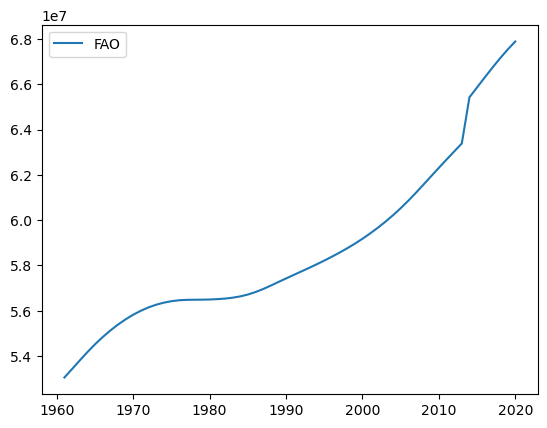

In [24]:
pop_uk_FAO = population_data.population.sel(Region=229)

plt.plot(np.arange(1961, 2021), pop_uk_FAO, label="FAO")
plt.legend()

In [25]:
population_encoding = {}
for data_var in population_data.data_vars:
    population_encoding[data_var] = {"dtype":"float32", "zlib": True, "complevel": 5}
    
population_data.to_netcdf("../population/data/Population_FAOSTAT.nc", encoding=population_encoding)

# Nutrient data

Lets compute the nutrients per mass of item, by taking the daily per capita intakes and dividing by the daily weight consumed per item

In [26]:
nutrient_data = xr.Dataset(
    data_vars = dict(

        kcal=(["Region", "Year", "Item"], fbs_arr[:,:,1]),
        protein=(["Region", "Year", "Item"], fbs_arr[:,:,2]),
        fat=(["Region", "Year", "Item"], fbs_arr[:,:,3]),
        
    ),
    coords = {
        "Region":("Region", area_codes),
        "Region_name":("Region", area_names),
        "Year":("Year", years),
        "Item":("Item", item_codes),
        "Item_name":("Item", item_names),     
        "Item_group":("Item", item_groups),     
        "Item_origin":("Item", item_origins),        
    }
)
nutrient_data

<xarray.Dataset>
Dimensions:      (Region: 230, Year: 60, Item: 117)
Coordinates:
  * Region       (Region) int64 1 2 3 4 7 8 9 ... 5707 5801 5802 5803 5815 5817
    Region_name  (Region) object 'Armenia' ... 'Net Food Importing Developing...
  * Year         (Year) int64 1961 1962 1963 1964 1965 ... 2017 2018 2019 2020
  * Item         (Item) int64 2511 2513 2514 2515 2516 ... 2948 2949 2960 2961
    Item_name    (Item) object 'Wheat and products' ... 'Aquatic Products, Ot...
    Item_group   (Item) <U24 'Cereals - Excluding Beer' ... 'Aquatic Products...
    Item_origin  (Item) <U16 'Vegetal Products' ... 'Animal Products'
Data variables:
    kcal         (Region, Year, Item) float64 nan nan nan ... 1.402e+07 0.0
    protein      (Region, Year, Item) float64 nan nan nan nan ... 11.0 23.0 0.0
    fat          (Region, Year, Item) float64 nan nan nan ... 2.142e+06 0.0

In [27]:
nutrient_data.sel(Region=229)

<xarray.Dataset>
Dimensions:      (Year: 60, Item: 117)
Coordinates:
    Region       int64 229
    Region_name  object 'United Kingdom of Great Britain and Northern Ireland'
  * Year         (Year) int64 1961 1962 1963 1964 1965 ... 2017 2018 2019 2020
  * Item         (Item) int64 2511 2513 2514 2515 2516 ... 2948 2949 2960 2961
    Item_name    (Item) object 'Wheat and products' ... 'Aquatic Products, Ot...
    Item_group   (Item) <U24 'Cereals - Excluding Beer' ... 'Aquatic Products...
    Item_origin  (Item) <U16 'Vegetal Products' ... 'Animal Products'
Data variables:
    kcal         (Year, Item) float64 nan nan nan nan ... 1.07e+06 1.105e+06 0.0
    protein      (Year, Item) float64 717.0 2.0 7.0 2.0 ... 340.0 43.0 45.0 0.0
    fat          (Year, Item) float64 nan nan nan ... 8.618e+04 1.404e+05 0.0

In [28]:
# (g_nutrient / cap / day) / (g_food / cap / day) = g_nutrient / g_food  

food_day_capita = data["food"]*1e9/population_data["population"]/365.25
nutrients_gram = nutrient_data / food_day_capita
nutrients_gram

<xarray.Dataset>
Dimensions:      (Region: 230, Year: 60, Item: 117)
Coordinates:
  * Region       (Region) int64 1 2 3 4 7 8 9 ... 5707 5801 5802 5803 5815 5817
    Region_name  (Region) object 'Armenia' ... 'Net Food Importing Developing...
  * Year         (Year) int64 1961 1962 1963 1964 1965 ... 2017 2018 2019 2020
  * Item         (Item) int64 2511 2513 2514 2515 2516 ... 2948 2949 2960 2961
    Item_name    (Item) object 'Wheat and products' ... 'Aquatic Products, Ot...
    Item_group   (Item) <U24 'Cereals - Excluding Beer' ... 'Aquatic Products...
    Item_origin  (Item) <U16 'Vegetal Products' ... 'Animal Products'
Data variables:
    kcal         (Region, Year, Item) float64 nan nan nan ... 7.027e+06 nan
    protein      (Region, Year, Item) float64 nan nan nan ... 6.59e+03 11.53 nan
    fat          (Region, Year, Item) float64 nan nan nan ... 1.073e+06 nan

In [31]:
nutrient_encoding = {}
for data_var in nutrients_gram.data_vars:
    nutrient_encoding[data_var] = {"dtype":"float32", "zlib": True, "complevel": 5}
    
nutrients_gram.to_netcdf("data/Nutrients_FAOSTAT.nc", encoding=nutrient_encoding)